In [10]:
!pip install rasterstats folium treeinterpreter

In [1]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

In [2]:
my_root_dir = "/home/jovyan/results/classified/"

In [3]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/home/jovyan/vector_data/clippedTrainingData.gpkg'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mappingtraining_data = '/home/jovyan/vector_data/training.geojson'
#training_vectors = gpd.read_file(training_data)
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()
training_vectors.shape

(49, 15)

In [4]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.typ)
classes

# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict     

{'Sandy areas': 0,
 'Vegetation 1': 1,
 'Vegetation 2': 2,
 'Vegetation 4': 3,
 'Vegetation 5': 4,
 'Water': 5}

In [5]:
# raster information

##If you want to read the data directly from the shared folder, uncomment the following line.
#raster_file = '/home/jovyan/results/10bands_to_aoi.tiff'
raster_file = '/home/jovyan/results/unet_input/4bands_202401.tiff'

# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.typ, training_vectors.geometry):
        # check CRS
        if training_vectors.crs != src.crs:
           training_vectors = training_vectors.to_crs(src.crs)
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])

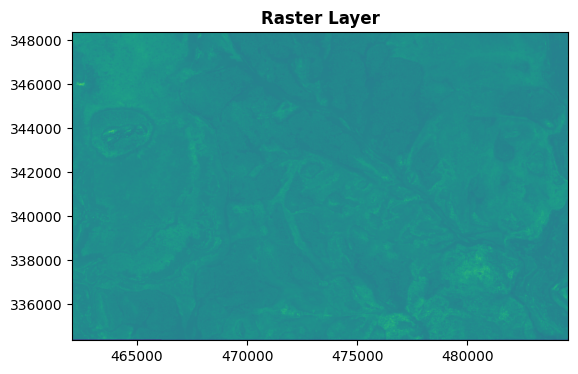

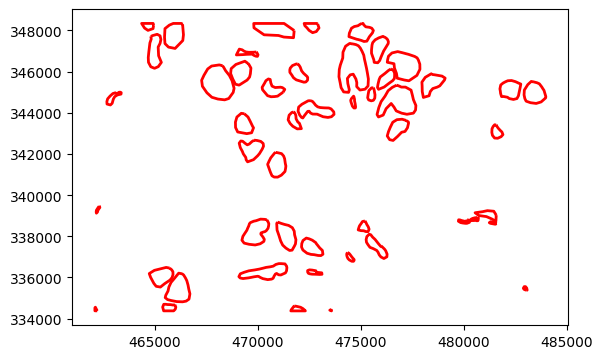

In [6]:
#'################################## test
#raster_file = '/home/jovyan/results/unet_input/rgb_nir_20231209.tif'

training_data = '/home/jovyan/vector_data/clippedTrainingData.gpkg'
training_vectors = gpd.read_file(training_data)

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt

# Assuming 'raster_file' is the path to your raster file
with rasterio.open(raster_file, 'r') as src:
    # Assuming 'mask' is your mask layer (boolean numpy array)
    
    # Create a GeoDataFrame for the mask
    #mask_gdf = gpd.GeoDataFrame({'geometry': [geometry for geom, value in rasterio.features.shapes(mask, transform=src.transform) if value]})
    if training_vectors.crs != src.crs:
        training_vectors = training_vectors.to_crs(src.crs)

    # Plot the raster
    show(src, title='Raster Layer')

    # Plot the mask overlay
    training_vectors.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=2)
    
    plt.show()


In [32]:
############### TEST ###################
#training_vectors


In [7]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((289426, 4), (289426,))

In [8]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

def savi_index(arr, a, b, L):
    return np.expand_dims(((arr[..., a] - arr[..., b]) / ((arr[..., a] + arr[..., b]) + L)) *(1 + L) , axis=1)

#def band_index(arr, a, b):
#    divisor = (arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b])
#    mask = divisor != 0  # Creating a mask to avoid division by zero
#    result = np.zeros_like(arr)
#    result[mask, :] = (arr[mask, a] - arr[mask, b]) / divisor[mask]
#    return np.expand_dims(result, axis=1)


#ndvi = band_index(X, 9, 3)
ndvi = band_index(X, 3, 1)
#ndwi = band_index(X, 2, 9)
#gndvi = band_index(X, 9, 2)
#savi = savi_index(X, 9, 3, 0.5)

#X = np.concatenate([X, ndvi, ndwi, gndvi, savi], axis=1)
X = np.concatenate([X, ndvi], axis=1)
X.shape

/tmp/ipykernel_76/2434233818.py:3: RuntimeWarning: invalid value encountered in divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)


(289426, 5)

In [9]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict


{0: 4.819579057965077e-06,
 1: 6.621639517944644e-05,
 2: 0.0006747638326585695,
 3: 0.00027586206896551725,
 4: 0.00026246719160104987,
 5: 0.029411764705882353}

In [11]:
#class_weight_dict[1] = 0.1
class_weight_dict

{0: 4.819579057965077e-06,
 1: 6.621639517944644e-05,
 2: 0.0006747638326585695,
 3: 0.00027586206896551725,
 4: 0.00026246719160104987,
 5: 0.029411764705882353}

In [12]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=50,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-5,
    verbose=1,
    random_state=0)


In [17]:
# set NaN to 1... to be clarified ;-)
X[np.isnan(X)] = 1


In [18]:
# fit the model to the data (training)
clf.fit(X, y)

[Parallel(n_jobs=-5)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-5)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-5)]: Done  50 out of  50 | elapsed:    3.1s finished


RandomForestClassifier(class_weight={0: 4.819579057965077e-06,
                                     1: 6.621639517944644e-05,
                                     2: 0.0006747638326585695,
                                     3: 0.00027586206896551725,
                                     4: 0.00026246719160104987,
                                     5: 0.029411764705882353},
                       max_depth=6, n_estimators=50, n_jobs=-5, random_state=0,
                       verbose=1)

In [19]:
from sklearn.impute import SimpleImputer

# Assuming X_test is your test data
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', depending on what you used for training
X_test_imputed = imputer.fit_transform(X_test)

In [20]:
# predict on X_test to evaluate the model

#preds = clf.predict(X_test)
preds = clf.predict(X_test_imputed)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


In [23]:
# (optional) save the trained model as python pickle file
model_name = op.join('/home/jovyan/results','sololo_jan24_random_forest.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

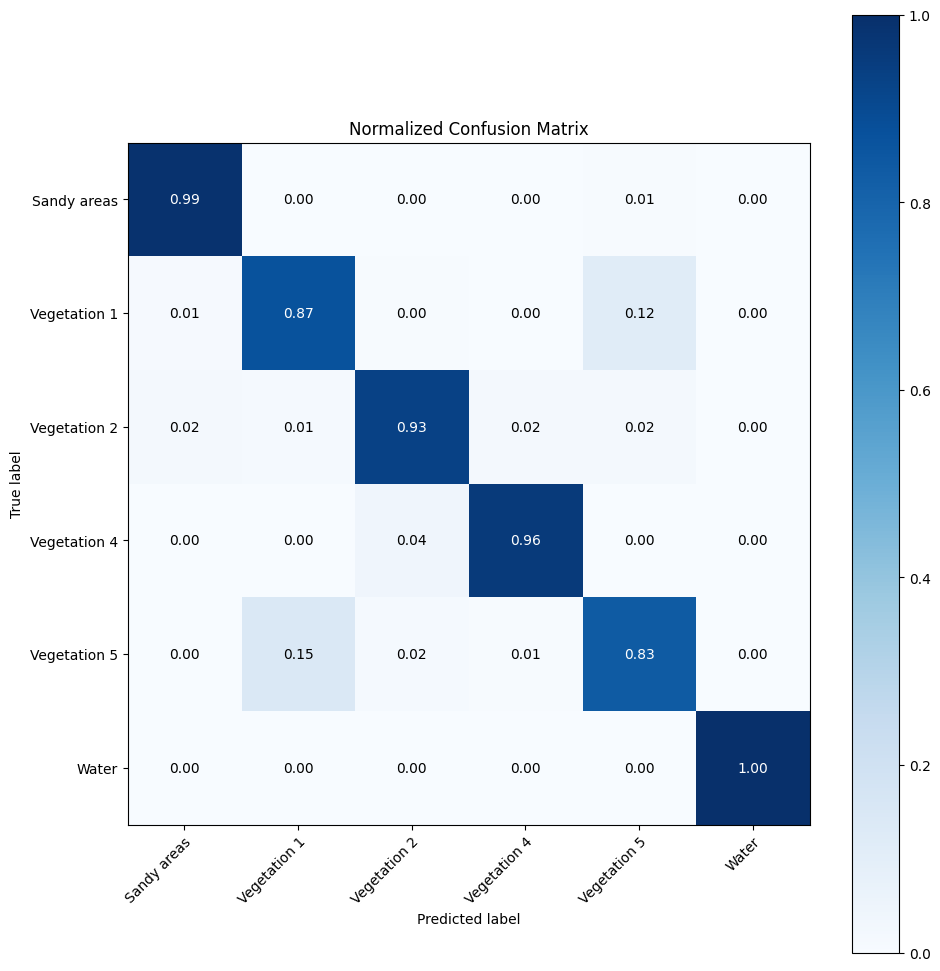

In [24]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [25]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [26]:
c

array([[  5.70981089,  -6.65214107,   2.40658641,   1.95401863,
         -2.82034333,  -0.59793152],
       [ 21.37630666,  -8.40689212,  -3.07948965,   1.53411681,
        -11.05842267,  -0.36561903],
       [ 29.13822814,   3.33956336, -15.46792491, -12.82349405,
         -0.34369907,  -3.84267347],
       [ 11.22018669,  -2.14234515,  -1.58096712,  -1.45999031,
         -1.34558211,  -4.69130199],
       [  3.36902659,   1.82872285,   2.45147126,  -3.66189162,
          1.94688319,  -5.93421227]])

In [31]:
# plot the contributions
band_names = [#'[0]1',
              '[1]Blue',
              '[2]Green',
              '[3]Red',
              #'[4]5',
              #'[5]6',
              #'[6]7',
              #'[7]SWIR',
              #'[8]SWIR',
              '[9]NIR',
              #'[10]NDVI',
              #'[11]NDWI',
              #'[12]GNDVI',
              #'[13]SAVI'
            ]

#gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf = gpd.GeoDataFrame(c, columns=classes)
gdf.style.background_gradient(cmap='RdYlGn')

,Sandy areas,Vegetation 1,Vegetation 2,Vegetation 4,Vegetation 5,Water
0,5.709811,-6.652141,2.406586,1.954019,-2.820343,-0.597932
1,21.376307,-8.406892,-3.079490,1.534117,-11.058423,-0.365619
2,29.138228,3.339563,-15.467925,-12.823494,-0.343699,-3.842673
3,11.220187,-2.142345,-1.580967,-1.459990,-1.345582,-4.691302
4,3.369027,1.828723,2.451471,-3.661892,1.946883,-5.934212


In [33]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "sololo_jan23_classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
               # img_ndwi = band_index(img_flat, 2, 9)
               # img_gndwi = band_index(img_flat, 9, 2)
               # img_savi = savi_index(img_flat, 9, 3, 0.5)

               # img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi, img_gndwi, img_savi], axis=1)
                img_w_ind = np.concatenate([img_flat, img_ndvi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                
                ###########

                # set NaN to 1... to be clarified ;-)
                img_w_ind[np.isnan(img_w_ind)] = 1
                
                # to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])
                to_predict = img_w_ind.reshape(-1, img_w_ind.shape[-1])

                ###########
                
                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

/tmp/ipykernel_76/2434233818.py:3: RuntimeWarning: invalid value encountered in divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished
/tmp/ipykernel_76/2434233818.py:3: RuntimeWarning: invalid value encountered in divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished
/tmp/ipykernel_76/2434233818.py:3: RuntimeWarning: invalid value encountered in divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
[Parallel(n_jobs=4)]: Using backend Threadin

In [34]:
print("Feature names:", clf.feature_importances_)


Feature names: [0.15563046 0.14764531 0.29763129 0.17568455 0.22340839]


<Axes: title={'center': 'S2 Data'}>

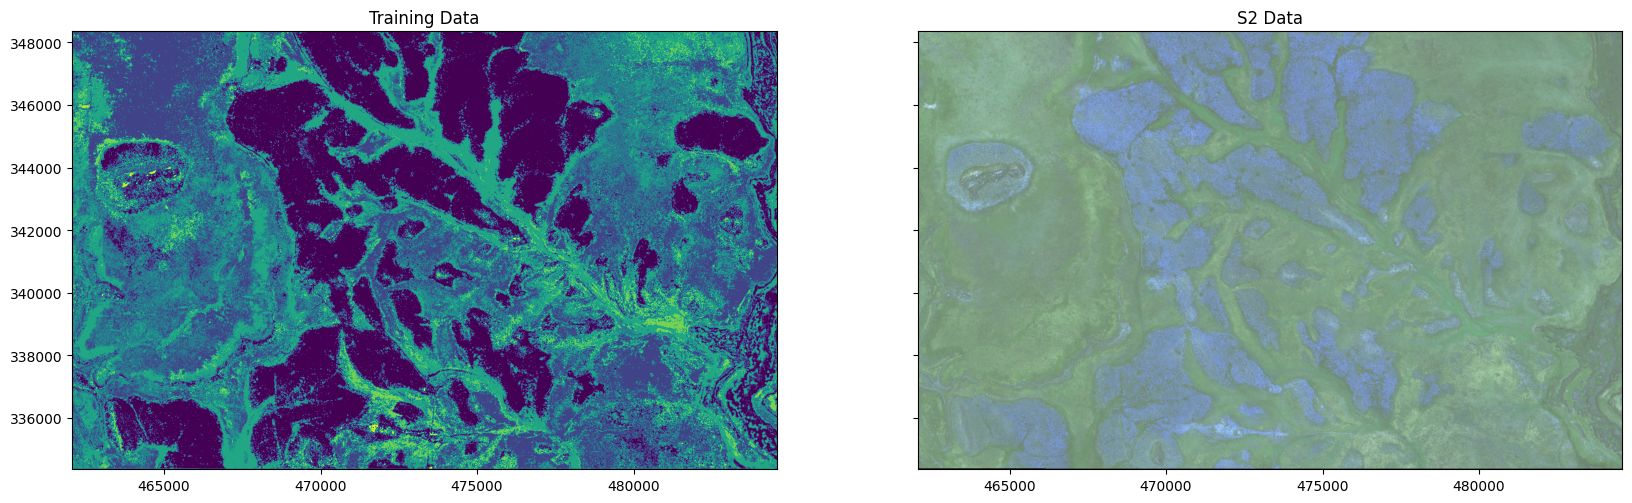

In [45]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/home/jovyan/results/classified/sololo_jan23_classification.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([3,2,1])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 16), sharey=True)

ax1.set_title("Classified Data")
ax2.set_title("S2 Data")

show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)

In [25]:
img_w_ind.shape[-1]

6

In [45]:
img_w_ind.shape
#img_w_ind[~m.mask].shape

(250000, 6)

In [49]:
import numpy as np

#arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
arr = img_w_ind[~m.mask]
newarr = arr.reshape(-1, 6)

print(newarr)

ValueError: cannot reshape array of size 1492516 into shape (6)

In [37]:
1492516/6

248752.66666666666

In [38]:
248753*6

1492518